<a href="https://colab.research.google.com/github/potulabe/symphonypy/blob/main/notebooks/Symphonypy_precomputed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symphonypy usage with pre-computed references

In [ ]:
!pip install scanpy[leiden] symphonypy

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import symphonypy as sp

sc.set_figure_params(dpi=80)
sns.set_style("ticks")

List of available datasets is [here](https://zenodo.org/record/7568342#.Y9FTIC8w1qs).

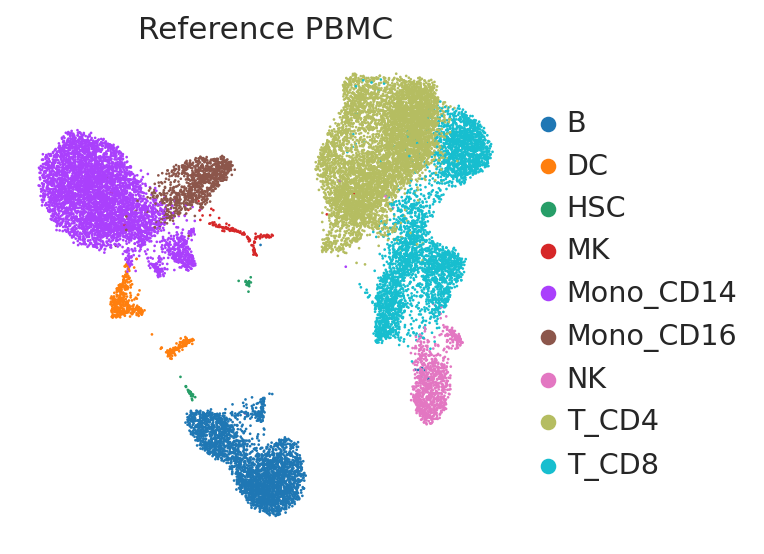

In [5]:
adata_ref = sp.datasets.pbmcs_10x_reference()
sc.pl.umap(
    adata_ref,
    color="cell_type",
    frameon=False,
    title="Reference PBMC",
)

Before Symphony label transfer query dataset should be log1p-normalized.

In [6]:
adata_query = sc.datasets.pbmc3k()

# Query preprocessing
sc.pp.normalize_total(adata_query, target_sum=1e4)
# target_sum=1e4 is prefered if you use pre-built references
sc.pp.log1p(adata_query)

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

In [7]:
# Mapping Harmony coordinates
sp.tl.map_embedding(adata_query=adata_query, adata_ref=adata_ref)

# Mapping UMAP coordinates
sp.tl.ingest(adata_query=adata_query, adata_ref=adata_ref)

# Labels prediction
sp.tl.transfer_labels_kNN(
    adata_query=adata_query,
    adata_ref=adata_ref,
    ref_labels="cell_type",
)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [8]:
# Per cell mapping score — optional
sp.tl.per_cell_confidence(
    adata_query=adata_query,
    adata_ref=adata_ref,
)

In [9]:
# Per cluster mapping score — optional
def cluster_data(adata, resolution=1):
  adata = adata.copy()
  sc.pp.scale(adata, max_value=10)
  sc.pp.pca(adata, n_comps=30)
  sc.pp.neighbors(adata)
  sc.tl.leiden(adata, resolution=resolution)
  return adata.obs["leiden"]

adata_query.obs["query_leiden"] = cluster_data(adata_query)

sp.tl.per_cluster_confidence(
    adata_query=adata_query,
    adata_ref=adata_ref,
    cluster_key="query_leiden",
)

<ipython-input-9-c8757db831cc>:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=resolution)


Results visualization.

In [10]:
# Matching cell type colors
adata_query.obs["cell_type"] = adata_query.obs["cell_type"].astype("category")
adata_query.uns["cell_type_colors"] = [dict(zip(
    adata_ref.obs["cell_type"].cat.categories,
    adata_ref.uns["cell_type_colors"],
))[ct] for ct in adata_query.obs["cell_type"].cat.categories]

<Axes: title={'center': 'Reference dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

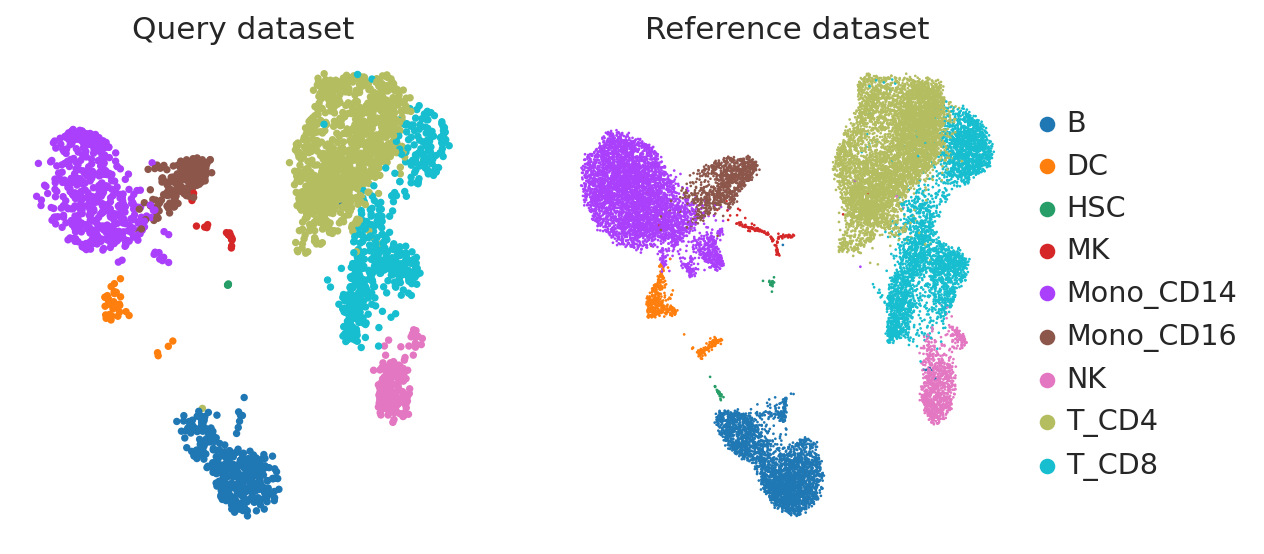

In [11]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sc.pl.umap(
    adata_query,
    color="cell_type",
    frameon=False,
    title="Query dataset",
    ax=axes[0],
    show=False,
    legend_loc=None,
)

sc.pl.umap(
    adata_ref,
    color="cell_type",
    frameon=False,
    title="Reference dataset",
    ax=axes[1],
    show=False,
)

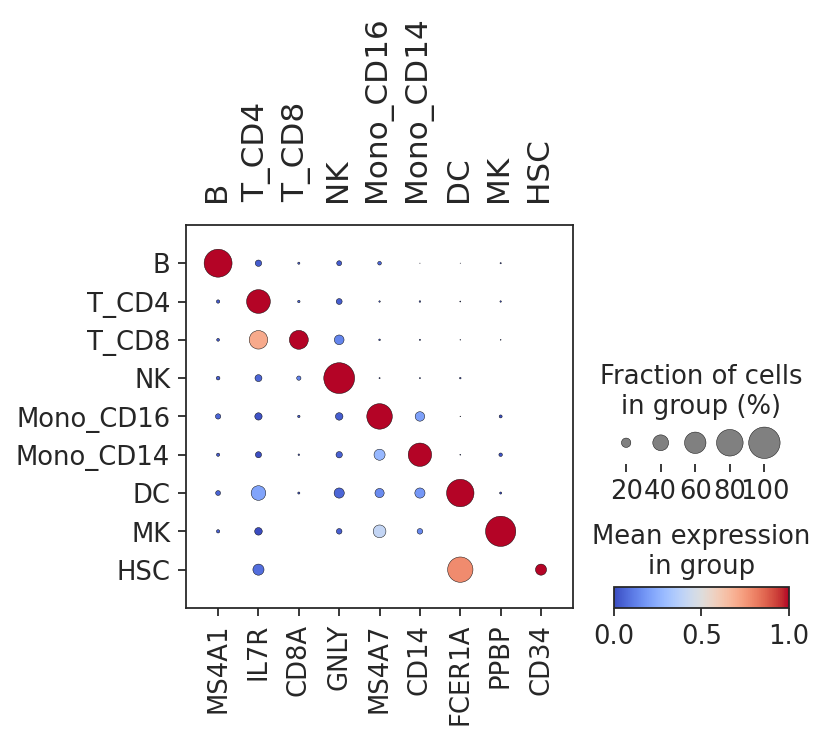

In [12]:
marker_genes = {
    "B": ["MS4A1"],
    "T_CD4": ["IL7R"],
    "T_CD8": ["CD8A"],
    "NK": ["GNLY"],
    "Mono_CD16": ["MS4A7"],
    "Mono_CD14": ["CD14"],
    "DC": ["FCER1A"],
    "MK": ["PPBP"],
    "HSC": ["CD34"],
}

adata_query.obs["cell_type"] = (
    adata_query.
    obs["cell_type"].
    cat.
    reorder_categories(
        list(marker_genes.keys())
    )
)

sc.pl.dotplot(
    adata_query,
    var_names=marker_genes,
    groupby="cell_type",
    standard_scale="var",
    dot_max=1,
    cmap="coolwarm",
)

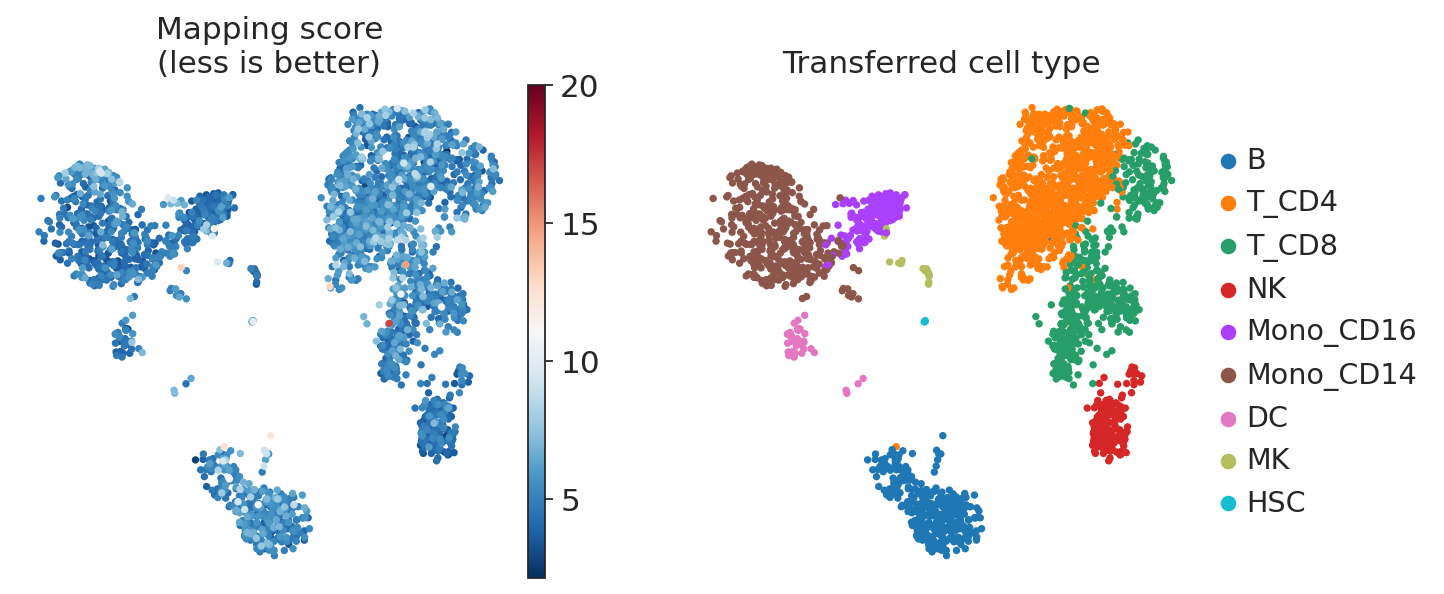

In [14]:
sc.pl.umap(
    adata_query,
    color=["symphony_per_cell_dist", "cell_type"],
    frameon=False,
    title=["Mapping score\n(less is better)", "Transferred cell type"],
    vmax=20,
    cmap="RdBu_r",
)

(0.0, 8.83061728686151)

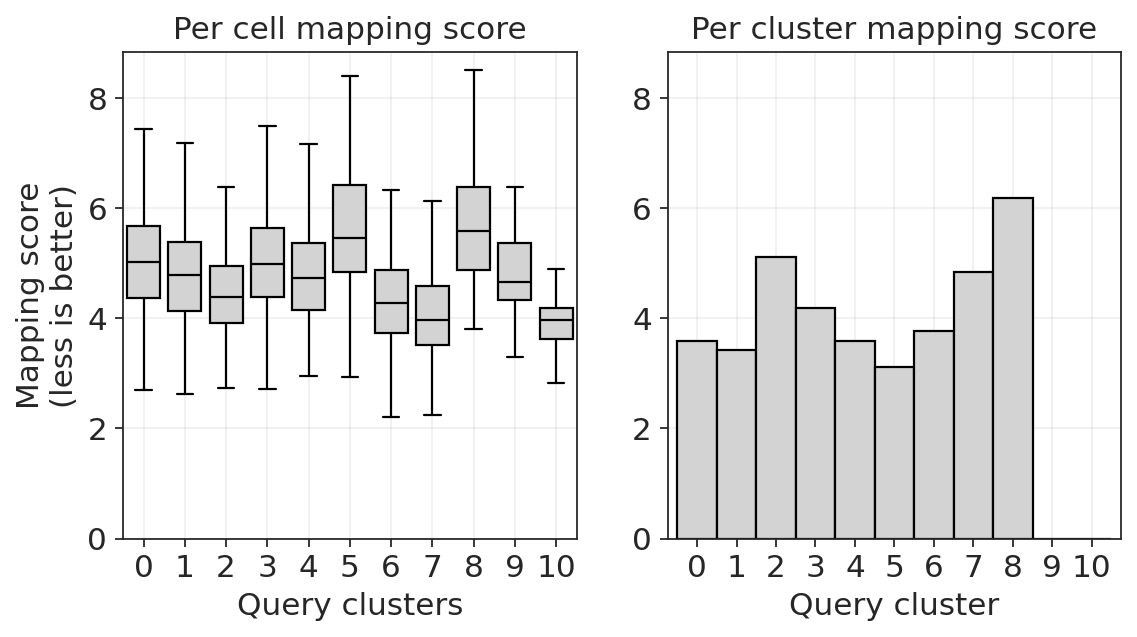

In [15]:
boxplot_colordict = {
    "boxprops": {"edgecolor": "black"},
    "medianprops": {"color": "black"},
    "whiskerprops": {"color": "black"},
    "capprops": {"color": "black"},
}

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sns.boxplot(
    x="query_leiden",
    y="symphony_per_cell_dist",
    data=adata_query.obs,
    showfliers=False,
    color="lightgrey",
    linewidth=1,
    ax=axes[0],
    **boxplot_colordict,
)
axes[0].set_xlabel("Query clusters")
axes[0].set_ylabel("Mapping score\n(less is better)")
axes[0].set_title("Per cell mapping score")
axes[0].grid(alpha=0.3)

adata_query.uns["symphony_per_cluster_dist"]["dist"].plot.bar(
    width=1,
    edgecolor="black",
    color="lightgrey",
    ax=axes[1],
)
axes[1].set_xlabel("Query cluster")
axes[1].set_title("Per cluster mapping score")
axes[1].grid(alpha=0.3)
axes[1].tick_params(axis="x", labelrotation=0)

ylim = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(0, ylim)
axes[1].set_ylim(0, ylim)